In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from geopy.geocoders import Nominatim

%matplotlib inline

In [294]:
#Import our pricing data
prices_df = pd.read_csv('Melbourne_housing_FULL.csv')
prices_df.head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
7,Abbotsford,16 Maugie St,4,h,NaN,SN,Nelson,6/08/2016,2.5,3067,...,2.0,2.0,400.0,220.0,2006.0,Yarra City Council,-37.7965,144.9965,Northern Metropolitan,4019.0
8,Abbotsford,53 Turner St,2,h,NaN,S,Biggin,6/08/2016,2.5,3067,...,1.0,2.0,201.0,NaN,1900.0,Yarra City Council,-37.7995,144.9974,Northern Metropolitan,4019.0
9,Abbotsford,99 Turner St,2,h,NaN,S,Collins,6/08/2016,2.5,3067,...,2.0,1.0,202.0,NaN,1900.0,Yarra City Council,-37.7996,144.9989,Northern Metropolitan,4019.0


In [295]:
#Fix the typos in the titles
prices_df=prices_df.rename(columns = {'Lattitude':'Latitude',
                                     'Longtitude':'Longitude'})
#See what type of data we are working with.
prices_df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode           int64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Latitude         float64
Longitude        float64
Regionname        object
Propertycount    float64
dtype: object

In [296]:
prices_df.Method.value_counts()

S     16799
SP     4241
PI     3941
VB     2456
SN     1187
PN      248
SA      193
W       125
SS       27
Name: Method, dtype: int64

In [297]:
# Drop variables that are strings and would require a lot of processing power to convert to dummies with likely little value add.
prices_df = prices_df.drop(['SellerG', 'Date'], 1)
# Count nulls 
null_count = prices_df.isnull().sum()
print(null_count[null_count>0])

print('The number of rows in this data set is: {}'.format(len(prices_df)))

Price             6367
Bedroom2          6552
Bathroom          6558
Car               6860
Landsize          9568
BuildingArea     17400
YearBuilt        15744
CouncilArea          2
Latitude          6339
Longitude         6339
Regionname           2
Propertycount        2
dtype: int64
The number of rows in this data set is: 29217


In [298]:
#Drop rows that don't have a Y variable since they won't do us good.
prices_df2 = prices_df.dropna(subset=['Price'])

#Drop Building area since the majority doesn't include this data.
prices_df2 = prices_df2.drop(['BuildingArea'], 1)
# Count nulls 
null_count = prices_df2.isnull().sum()
print(null_count[null_count>0])
print('The number of rows in this data set is: {}'.format(len(prices_df2)))

Bedroom2          5113
Bathroom          5117
Car               5347
Landsize          7495
YearBuilt        12376
CouncilArea          2
Latitude          4949
Longitude         4949
Regionname           2
Propertycount        2
dtype: int64
The number of rows in this data set is: 22850


In [299]:
prices_df2.Landsize.value_counts()

0.0        1942
650.0       127
697.0        81
585.0        60
534.0        55
700.0        53
604.0        48
590.0        47
696.0        45
400.0        42
600.0        41
603.0        39
627.0        39
586.0        38
581.0        38
530.0        38
649.0        38
725.0        37
557.0        37
695.0        36
654.0        36
531.0        36
612.0        34
597.0        33
602.0        33
592.0        33
583.0        32
588.0        32
613.0        32
605.0        31
           ... 
1880.0        1
1588.0        1
1055.0        1
1218.0        1
3806.0        1
2120.0        1
3381.0        1
1590.0        1
5750.0        1
1271.0        1
4786.0        1
5497.0        1
49.0          1
56.0          1
30.0          1
8220.0        1
6186.0        1
4657.0        1
1301.0        1
15100.0       1
1315.0        1
2226.0        1
4221.0        1
1912.0        1
1188.0        1
1247.0        1
1058.0        1
1364.0        1
3901.0        1
1850.0        1
Name: Landsize, Length: 

In [300]:
#Lots of zeros. Let's replace them with None
prices_df2['Landsize'] = prices_df2['Landsize'].replace({0:np.nan})

In [301]:
#Let's figure out where the Council Areas are
print(prices_df2[prices_df2.CouncilArea.isnull()])

           Suburb           Address  Rooms Type     Price Method  Distance  \
18523   Footscray  2/16 Stafford St      2    u  710000.0      S       5.1   
26888  Camberwell   2/3 Kingsley St      2    h  825000.0     VB       7.7   

       Postcode  Bedroom2  Bathroom  Car  Landsize  YearBuilt CouncilArea  \
18523      3011       NaN       NaN  NaN       NaN        NaN         NaN   
26888      3124       NaN       NaN  NaN       NaN        NaN         NaN   

       Latitude  Longitude Regionname  Propertycount  
18523       NaN        NaN        NaN            NaN  
26888       NaN        NaN        NaN            NaN  


In [302]:
#It appears they are in these Postcodes. Let's look up where others are:
print(prices_df2[prices_df2.Postcode == 3011])
print(prices_df2[prices_df2.Postcode == 3124])

          Suburb               Address  Rooms Type      Price Method  \
4377   Footscray      4/33 Ballarat Rd      3    t   585000.0      S   
4378   Footscray      202/51 Gordon St      1    u    85000.0     PI   
4379   Footscray         4 Adelaide St      4    h  1225000.0     SP   
4380   Footscray      11/44 Everard St      2    u   431000.0     SP   
4381   Footscray            9 Lynch St      3    h  1003000.0      S   
4382   Footscray     25 Southampton St      3    h   840000.0      S   
4383   Footscray        37 Stirling St      3    h  1362000.0      S   
4384   Footscray   58 Wolverhampton St      4    h   977000.0      S   
4385   Footscray       2/3 Eldridge St      1    u   216000.0      S   
4386   Footscray       8 Buckingham St      3    h   876000.0      S   
4387   Footscray       1/3 Eldridge St      1    u   227000.0      S   
4388   Footscray       1/15 Geelong Rd      4    t   841000.0      S   
4389   Footscray      9/55 Moreland St      2    u   605000.0   

           Suburb                 Address  Rooms Type      Price Method  \
2618   Camberwell          28 Brinsley Rd      4    h  2650000.0      S   
2619   Camberwell        2/1 Glen Iris Rd      3    t  1615000.0      S   
2621   Camberwell          1288 Toorak Rd      4    h  3225000.0     SA   
2623   Camberwell          1/806 Burke Rd      2    u  1017000.0      S   
2624   Camberwell        4/2 Callanish Rd      2    u   729000.0      S   
2625   Camberwell        49 Christowel St      5    h  2600000.0     VB   
2631   Camberwell  3/107 Wattle Valley Rd      3    h  1650000.0      S   
2636   Camberwell         19 Ellsworth Cr      3    t  1175000.0     VB   
2637   Camberwell           64 Fordham Av      5    h  2240000.0      S   
2639   Camberwell         22 Netherway St      5    h  2860000.0     PI   
2642   Camberwell            81 Rowell Av      3    h  1910000.0     PI   
2643   Camberwell     1/569 Camberwell Rd      2    h   950000.0     SP   
2644   Camberwell        

In [303]:
#Footscray is in Western Metropolitan and Maribyrnong City Council and property count = 
prices_df2.loc[18523, 'CouncilArea'] = 'Maribyrnong City Council'
prices_df2.loc[18523, 'Regionname'] = 'Western Metropolitan'
prices_df2.loc[18523, 'Propertycount'] = 7570.0

#Camberwell is in Southern Metropolitan and Boroondara City Council and property count = 8920.0
prices_df2.loc[26888, 'CouncilArea'] = 'Boroondara City Council'
prices_df2.loc[26888, 'Regionname'] = 'Southern Metropolitan'
prices_df2.loc[26888, 'Propertycount'] = 8920.0

#This should fix those two nulls.
null_count = prices_df2.isnull().sum()
print(null_count[null_count>0])

Bedroom2      5113
Bathroom      5117
Car           5347
Landsize      9437
YearBuilt    12376
Latitude      4949
Longitude     4949
dtype: int64


In [304]:
years = prices_df2.YearBuilt.unique()
print(sorted(years))
baths = prices_df2.Bathroom.unique()
print(sorted(baths))
cars = prices_df2.Car.unique()
print(sorted(cars))
beds = prices_df2.Bedroom2.unique()
print(sorted(beds))

[nan, 1196.0, 1820.0, 1830.0, 1850.0, 1854.0, 1856.0, 1857.0, 1860.0, 1862.0, 1863.0, 1868.0, 1870.0, 1872.0, 1875.0, 1877.0, 1880.0, 1881.0, 1884.0, 1885.0, 1886.0, 1887.0, 1888.0, 1889.0, 1890.0, 1892.0, 1893.0, 1894.0, 1895.0, 1896.0, 1897.0, 1898.0, 1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1906.0, 1907.0, 1908.0, 1910.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 19

In [305]:
#Clean up the typographical error
prices_df2['YearBuilt'] = prices_df2['YearBuilt'].replace([1196.0], 1916)

In [306]:
#Sort by the 207 unique postcodes and fill in nulls with averages of houses in the same postcode
postcodes_list = sorted(prices_df2.Postcode.unique())
print(postcodes_list)

[3000, 3002, 3003, 3006, 3008, 3011, 3012, 3013, 3015, 3016, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3046, 3047, 3048, 3049, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3064, 3065, 3066, 3067, 3068, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3078, 3079, 3081, 3082, 3083, 3084, 3085, 3087, 3088, 3089, 3090, 3093, 3094, 3095, 3096, 3099, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3111, 3113, 3115, 3116, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3158, 3160, 3161, 3162, 3163, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 320

In [307]:
#Create a function to automate the task of breaking the df down by Postcode and taking means/medians.
#First create the list for our means/medians
bedmedianlist = []
bathmedianlist = []
carmedianlist = []
yearmeanlist = []
landsizemeanlist = []
latmeanlist = []
longmeanlist = []

#Now the function
def postal(post, df):
    #Break out the values in this postcode into its own df
    
    postcode_df = df[df.Postcode == post]

    #Get our medians--if outliers are a concern--and averages
    bedmedian = np.nanmedian(postcode_df.Bedroom2)
    bathmedian = np.nanmedian(postcode_df.Bathroom)
    carmedian = np.nanmedian(postcode_df.Car)
    yearmean = round(np.nanmean(postcode_df.YearBuilt), 0)
    landsizemean = round(np.nanmean(postcode_df.Landsize), 0)
    latmean = round(np.nanmean(postcode_df.Latitude), 0)
    longmean = round(np.nanmean(postcode_df.Longitude), 0)
    bedmedianlist.append(bedmedian)
    bathmedianlist.append(bathmedian)
    carmedianlist.append(carmedian)
    yearmeanlist.append(yearmean)
    landsizemeanlist.append(landsizemean)
    latmeanlist.append(latmean)
    longmeanlist.append(longmean)

#Run it for all the postcodes in our list we created above
for x in postcodes_list:
    postal(x, prices_df2)
#See our results
print(bedmedianlist, bathmedianlist, carmedianlist, yearmeanlist, landsizemeanlist, latmeanlist, longmeanlist)   

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/Users/bryancorder/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


[2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, nan, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.5, 4.0, 4.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 2.0, nan, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.5, 4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.5, 5.0, 4.0, 3.5, 3.0, 4.0, 3.0, 3.0, 4.0, 3.5, 3.5,

In [308]:
#Create a key in the form of a new database
averages_df = pd.DataFrame({'Postcode': postcodes_list, 'Bedroom2': bedmedianlist, 'Bathroom': bathmedianlist,
                            'Car': carmedianlist, 'YearBuilt': yearmeanlist, 'Landsize': landsizemeanlist,
                            'Latitude': latmeanlist, 'Longitude': longmeanlist})
#Since we had some NaNs above and the list is in order by Postcode and Postcodes tend to be near each other, let's forward fill
averages_df = averages_df.fillna(method='ffill')

print(averages_df)

     Bathroom  Bedroom2  Car  Landsize  Latitude  Longitude  Postcode  \
0         1.0       2.0  1.0    1738.0     -38.0      145.0      3000   
1         1.0       2.0  1.0     525.0     -38.0      145.0      3002   
2         1.0       3.0  1.0     286.0     -38.0      145.0      3003   
3         1.0       2.0  1.0    2773.0     -38.0      145.0      3006   
4         2.0       2.0  2.0    2773.0     -38.0      145.0      3008   
5         1.0       2.0  1.0     403.0     -38.0      145.0      3011   
6         1.0       3.0  2.0     482.0     -38.0      145.0      3012   
7         1.0       3.0  2.0     364.0     -38.0      145.0      3013   
8         1.0       3.0  2.0     438.0     -38.0      145.0      3015   
9         2.0       3.0  2.0     386.0     -38.0      145.0      3016   
10        1.0       3.0  2.0     460.0     -38.0      145.0      3018   
11        1.0       3.0  2.0     588.0     -38.0      145.0      3019   
12        1.0       3.0  2.0     550.0     -38.0   

In [309]:
#Use our new Average dataframe as the key for replacing values in our original database
prices_df2.Bedroom2 = prices_df2.Bedroom2.mask(prices_df2.Bedroom2.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Bedroom2))
prices_df2.Bathroom = prices_df2.Bathroom.mask(prices_df2.Bathroom.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Bathroom))
prices_df2.Car = prices_df2.Car.mask(prices_df2.Car.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Car))
prices_df2.Landsize = prices_df2.Landsize.mask(prices_df2.Landsize.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Landsize))
prices_df2.YearBuilt = prices_df2.YearBuilt.mask(prices_df2.YearBuilt.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').YearBuilt))
prices_df2.Latitude = prices_df2.Latitude.mask(prices_df2.Latitude.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Latitude))
prices_df2.Longitude = prices_df2.Longitude.mask(prices_df2.Longitude.eq(0)).fillna(
    prices_df2.Postcode.map(averages_df.set_index('Postcode').Longitude))

#See if it worked
null_count = prices_df2.isnull().sum()
print(null_count[null_count>0])

Series([], dtype: int64)


In [310]:
start = datetime.now()
#Let's use geopy to get the Lat/Longs based on Full Addresses
no_latlong = prices_df2[prices_df2.Latitude.isnull()]
no_latlong['FullAddress'] = no_latlong.Address.str.cat(no_latlong.Suburb, sep=' ')

#Setup geolocator
geolocator = Nominatim()

#Create lists to store our results for merging
lat = []
long = []
address = []

def latlongfind(row):
    address.append(row['Address'])
    try:
        location = geolocator.geocode(row['FullAddress'])
        lat.append(location.latitude)
        long.append(location.longitude)
    except:
        lat.append(0)
        long.append(0)

no_latlong.apply(latlongfind, axis=1)        
print('It took the following time to complete this task:', datetime.now() - start)       

It took the following time to complete this task: 0:00:00.020615


In [311]:
latlong_df = pd.DataFrame({'Address': address, 'Latitude': lat, 'Longitude': long})
#Since we had some NaNs above and the list is in order by Postcode and Postcodes tend to be near each other, let's forward fill
no_latlong.Latitude = no_latlong.Latitude.mask(no_latlong.Latitude.eq(0)).fillna(
    no_latlong.Address.map(latlong_df.set_index('Address').Latitude))
no_latlong.Longitude = no_latlong.Longitude.mask(no_latlong.Longitude.eq(0)).fillna(
    no_latlong.Address.map(latlong_df.set_index('Address').Longitude))

prices_df2.Latitude = prices_df2.Latitude.mask(prices_df2.Latitude.eq(0)).fillna(
    prices_df2.Address.map(no_latlong.set_index('Address').Latitude))
prices_df2.Longitude = prices_df2.Longitude.mask(prices_df2.Longitude.eq(0)).fillna(
    prices_df2.Address.map(no_latlong.set_index('Address').Longitude))

#Forward fill the rest of them
prices_df2['Latitude'] = prices_df2['Latitude'].replace({0:np.nan})
prices_df2['Longitude'] = prices_df2['Longitude'].replace({0:np.nan})
null_count = prices_df2.isnull().sum()
print(null_count[null_count>0])

prices_df2 = prices_df2.fillna(method='ffill')

null_count = prices_df2.isnull().sum()
print(null_count[null_count>0])

Series([], dtype: int64)
Series([], dtype: int64)


In [312]:
prices_df2.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Latitude,Longitude,Propertycount
count,22850.000000,2.285000e+04,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000,22850.000000
mean,2.974661,1.056543e+06,10.919589,3111.005033,2.972735,1.552932,1.744048,695.950985,1966.876105,-37.849918,144.997414,7534.028534
std,0.962338,6.466137e+05,6.491734,104.201447,0.886547,0.658463,0.812740,3384.242342,26.807175,0.110674,0.102070,4487.590274
min,1.000000,8.500000e+04,0.000000,3000.000000,1.000000,1.000000,0.000000,1.000000,1820.000000,-38.185600,144.000000,83.000000
25%,2.000000,6.370000e+05,6.400000,3046.000000,2.000000,1.000000,1.000000,411.000000,1955.000000,-37.953695,144.953993,4280.000000
50%,3.000000,8.800000e+05,10.200000,3088.000000,3.000000,1.000000,2.000000,566.000000,1970.000000,-37.834660,145.000000,6567.000000
75%,4.000000,1.300000e+06,13.800000,3151.750000,3.000000,2.000000,2.000000,677.000000,1980.000000,-37.767600,145.047540,10331.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,20.000000,9.000000,18.000000,433014.000000,2018.000000,-37.000000,145.526350,21650.000000


In [313]:
# 75% of the prices are below 1,300,000, but the mean is 1,056,543 meaning our data is not balanced.
expensive = prices_df2[prices_df2.Price > 3000000]
print(len(expensive))
prices_df2 = prices_df2[prices_df2.Price < 3000000]
prices_df2['Price'].nlargest(10)


383


12524    2990000.0
13345    2990000.0
21976    2990000.0
5087     2980000.0
26354    2980000.0
4578     2975000.0
6457     2960000.0
14848    2960000.0
6753     2956000.0
616      2950000.0
Name: Price, dtype: float64

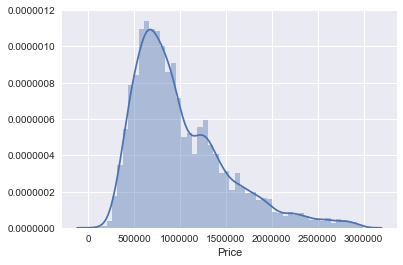

In [314]:
x = prices_df2['Price']
sns.distplot(x)

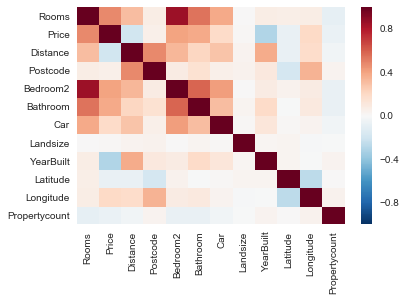

In [315]:
sns.heatmap(prices_df2.corr())

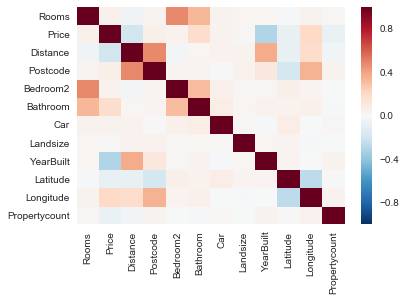

In [316]:
#Bedroom2 and Rooms are very similar, so let's create a new variable by centering and squaring
ls = ['Rooms', 'Bedroom2', 'Bathroom', 'Car']
def center_square(x):
    prices_df2[x] = (prices_df2[x] - np.mean(prices_df2[x])) ** 2
    return

center_square(ls)
    
sns.heatmap(prices_df2.corr())

In [317]:
start = datetime.now()
prices_df2 = prices_df2.drop(['Address'], 1)
prices_df2 = pd.get_dummies(prices_df2, columns=['Type','Method', 'CouncilArea', 'Suburb', 'Regionname'])
print(len(list(prices_df2.columns.values)))
print('It took the following time to complete this task:', datetime.now() - start) 

401
It took the following time to complete this task: 0:00:00.230257


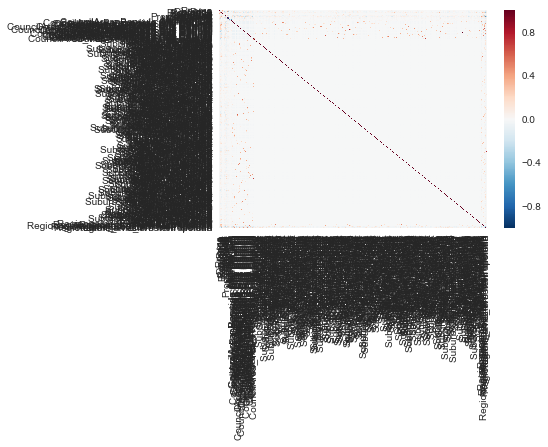

In [318]:
sns.heatmap(prices_df2.corr())

In [319]:
#Set our X,y
X = prices_df2.drop(['Price'], 1)
y = np.log(prices_df2['Price'])

#Make a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


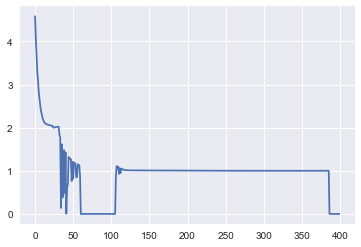

In [320]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X_train)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

In [321]:
#Set up our first X using PCA
pca = PCA(n_components=25)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

#Now for the Test
pca = PCA(n_components=25)
X_std_pca = pca.fit_transform(X_test)
X1_test = pd.DataFrame(X_std_pca)

In [322]:
# Let's use Random Forest to select features.
start = datetime.now()
X = X_train
y = y_train
clf = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
df2 = X.columns.get_values()
feat_labels = df2.tolist()

# Train the classifier
clf.fit(X, y)
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
for feature in zip(X, clf.feature_importances_):
    print(feature)

print('It took the following time to complete this task:', datetime.now() - start)

('Rooms', 0.11043303164345869)
('Distance', 0.1242855769446405)
('Postcode', 0.024807786615097187)
('Bedroom2', 0.0080427749847121824)
('Bathroom', 0.010933938824211077)
('Car', 0.0057702455332951999)
('Landsize', 0.055877281003964455)
('YearBuilt', 0.025399109632207432)
('Latitude', 0.033584569507453435)
('Longitude', 0.037906583699208275)
('Propertycount', 0.014564113725757274)
('Type_h', 0.010352445108843918)
('Type_t', 0.009935979646927915)
('Type_u', 0.23756971615290182)
('Method_PI', 0.0042792621943751772)
('Method_S', 0.0064800783688741407)
('Method_SA', 0.00019864879845026351)
('Method_SP', 0.0025168136047700744)
('Method_VB', 0.0034957337921663347)
('CouncilArea_Banyule City Council', 0.001177813015396188)
('CouncilArea_Bayside City Council', 0.00039168371273126559)
('CouncilArea_Boroondara City Council', 0.00039519026506778187)
('CouncilArea_Brimbank City Council', 0.00061229778914147312)
('CouncilArea_Cardinia Shire Council', 1.70254335838411e-05)
('CouncilArea_Casey City Co

In [323]:
start = datetime.now()
sfm = SelectFromModel(clf, threshold=0.001)
rfcfeature_list =[]
# Train the selector
sfm.fit(X, y)
for feature_list_index in sfm.get_support(indices=True):
    rfcfeature_list.append(feat_labels[feature_list_index])
    print(feat_labels[feature_list_index])

X2 = X_train[rfcfeature_list]
X2_test = X_test[rfcfeature_list]
     
print('Number of features in this list: {}'.format(len(rfcfeature_list)))
print('It took the following time to complete this task:', datetime.now() - start)

Rooms
Distance
Postcode
Bedroom2
Bathroom
Car
Landsize
YearBuilt
Latitude
Longitude
Propertycount
Type_h
Type_t
Type_u
Method_PI
Method_S
Method_SP
Method_VB
CouncilArea_Banyule City Council
CouncilArea_Hume City Council
CouncilArea_Kingston City Council
CouncilArea_Monash City Council
CouncilArea_Moonee Valley City Council
Suburb_Hampton
Regionname_Eastern Metropolitan
Regionname_South-Eastern Metropolitan
Regionname_Southern Metropolitan
Number of features in this list: 27
It took the following time to complete this task: 0:04:42.084900


In [324]:
#Make a list to store our results for a comparison at the end
results = pd.DataFrame(index=range(10))
results['Model'] = ['Lasso Regression',
                    'Lasso Regression',
                    'SVC', 'SVC',
                    'Decision Tree', 'Decision Tree',
                    'Random Forest',
                    'Random Forest',
                    'Gradient Booster',
                    'Gradient Booster'
                    ]
results['Feature Selection'] = ['PCA', 'Random Forest',
                               'PCA', 'Random Forest',
                                'PCA', 'Random Forest',
                               'PCA', 'Random Forest',
                               'PCA', 'Random Forest']


Train_Score = []
Test_Score = []
Cross_Validation = []
fold1 = []
fold2 = []
fold3 = []
fold4 = []
fold5 = []

In [325]:
def testing_func(test):
    #Fit the models
    test.fit(X1, y)
    #Generate the score
    score1 = test.score(X1, y)
    # Print out the results.
    print('\nR-squared for the training set with PCA:')
    print(score1)
    #Put that score into a list we can use later to compare results.
    Train_Score.append(score1)
    
    #Rinse and repeat
    test.fit(X1_test, y_test)
    score2 = test.score(X1_test, y_test)
    Test_Score.append(score2)
    print('\nR-squared for the test set with PCA:')
    print(score2)
    
    test.fit(X2, y)
    score3 = test.score(X2, y)
    Train_Score.append(score3)
    test.fit(X2_test, y_test)
    score4 = test.score(X2_test, y_test)
    Test_Score.append(score4)

    
    #Check with Cross Validation
    Cross_Validation0 = cross_val_score(test, X1, y, cv=5)
    print('\nCross Validation Score with 5 folds with PCA:\n{}'.format(Cross_Validation0))
    Cross_Validation.append(Cross_Validation0)
    
    #Break up the cross validation results into seperate lists to be put into our data frame for comparison later.
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])
    print('\nR-squared for the training set with Random Forest generated features:')
    print(score3)
    print('\nR-squared for the test set with Random Forest generated features:')
    print(score4)
    Cross_Validation0 = cross_val_score(test, X2, y, cv=5)
    print('\nCross Validation Score with 5 folds with Random Forest generated feature:\n{}'.format(Cross_Validation0))
    Cross_Validation.append(Cross_Validation0)
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])


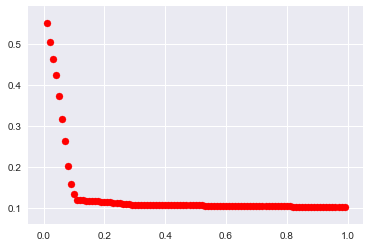

In [326]:
numb = np.arange(0.01, 1, 0.01)
yl = []

for g in numb:
    lassBig = linear_model.Lasso(alpha=g)
    lassBig.fit(X1, y)
    yl.append(lassBig.score(X1, y))
    
plt.scatter(numb, yl, c='r')

plt.show()

In [327]:
start = datetime.now()
lasso = linear_model.Lasso(alpha=1)
testing_func(lasso)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.101125309082

R-squared for the test set with PCA:
0.0920123887768

Cross Validation Score with 5 folds with PCA:
[ 0.09999062  0.08937958  0.1075609   0.09448868  0.10704224]

R-squared for the training set with Random Forest generated features:
0.0995118725069

R-squared for the test set with Random Forest generated features:
0.0904478913686

Cross Validation Score with 5 folds with Random Forest generated feature:
[ 0.09835383  0.08783472  0.10566768  0.09305385  0.10529799]
It took the following time to complete this task: 0:00:00.573683


In [328]:
svr = SVR()
parameters = {'C':[1,2,3,4,5,6,7,8,9,10], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]}
grid = GridSearchCV(svr, parameters)
grid.fit(X1, y)
predicted = grid.predict(X1_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_

The best parameters are {'C': 10, 'gamma': 0.01} with a score of %0.36831326071176745


In [329]:
start = datetime.now()
#Now let's model with SVM
svr = SVR(C=parameters['C'], gamma=parameters['gamma'])
testing_func(svr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.917785036984

R-squared for the test set with PCA:
0.926973434392

Cross Validation Score with 5 folds with PCA:
[ 0.40078563  0.39735393  0.40083203  0.38611346  0.37893555]

R-squared for the training set with Random Forest generated features:
0.918177654739

R-squared for the test set with Random Forest generated features:
0.927452642502

Cross Validation Score with 5 folds with Random Forest generated feature:
[ 0.40114976  0.3976812   0.40118572  0.38614691  0.37892309]
It took the following time to complete this task: 0:08:49.327393


In [330]:
start = datetime.now()
regressor = DecisionTreeRegressor(max_depth=8, random_state=0)
testing_func(regressor)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.734866127765

R-squared for the test set with PCA:
0.756104377164

Cross Validation Score with 5 folds with PCA:
[ 0.62025116  0.63694864  0.64505463  0.63894704  0.64190534]

R-squared for the training set with Random Forest generated features:
0.762957351786

R-squared for the test set with Random Forest generated features:
0.789822656135

Cross Validation Score with 5 folds with Random Forest generated feature:
[ 0.73380777  0.70312724  0.72987085  0.71059081  0.73087943]
It took the following time to complete this task: 0:00:03.683157


In [331]:
start = datetime.now()
#Now let's model with Random Forest
rfc = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=8, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                            bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                            warm_start=False)

testing_func(rfc)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.77468708446

R-squared for the test set with PCA:
0.798141165066

Cross Validation Score with 5 folds with PCA:
[ 0.7265185   0.70745644  0.73912074  0.70734137  0.7199744 ]

R-squared for the training set with Random Forest generated features:
0.798754079482

R-squared for the test set with Random Forest generated features:
0.822552462812

Cross Validation Score with 5 folds with Random Forest generated feature:
[ 0.77511431  0.7529821   0.78325091  0.75427738  0.77492326]
It took the following time to complete this task: 0:04:28.322808


In [332]:
start = datetime.now()
#Now let's model with Gradient Boosting
regr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=500, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features=None,
                                 alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

testing_func(regr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.848865218291

R-squared for the test set with PCA:
0.87260362064

Cross Validation Score with 5 folds with PCA:
[ 0.79831741  0.77750699  0.81118092  0.7786543   0.79132001]

R-squared for the training set with Random Forest generated features:
0.858481213867

R-squared for the test set with Random Forest generated features:
0.872526437276

Cross Validation Score with 5 folds with Random Forest generated feature:
[ 0.83705011  0.82522446  0.8471913   0.82147247  0.83487794]
It took the following time to complete this task: 0:05:59.203501


In [333]:
results2 = pd.DataFrame({'Train Score': Train_Score, 'Test Score': Test_Score, 'CV Fold 1': fold1,
                            'CV Fold 2': fold2, 'CV Fold 3': fold3, 'CV Fold 4': fold4, 'CV Fold 5': fold5})
results = pd.concat([results, results2], axis=1)

results.head(10)

,Model,Feature Selection,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5,Test Score,Train Score
0,Lasso Regression,PCA,0.099991,0.089380,0.107561,0.094489,0.107042,0.092012,0.101125
1,Lasso Regression,Random Forest,0.098354,0.087835,0.105668,0.093054,0.105298,0.090448,0.099512
2,SVC,PCA,0.400786,0.397354,0.400832,0.386113,0.378936,0.926973,0.917785
3,SVC,Random Forest,0.401150,0.397681,0.401186,0.386147,0.378923,0.927453,0.918178
4,Decision Tree,PCA,0.620251,0.636949,0.645055,0.638947,0.641905,0.756104,0.734866
5,Decision Tree,Random Forest,0.733808,0.703127,0.729871,0.710591,0.730879,0.789823,0.762957
6,Random Forest,PCA,0.726518,0.707456,0.739121,0.707341,0.719974,0.798141,0.774687
7,Random Forest,Random Forest,0.775114,0.752982,0.783251,0.754277,0.774923,0.822552,0.798754
8,Gradient Booster,PCA,0.798317,0.777507,0.811181,0.778654,0.791320,0.872604,0.848865
9,Gradient Booster,Random Forest,0.837050,0.825224,0.847191,0.821472,0.834878,0.872526,0.858481


In [334]:
results.describe()

,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5,Test Score,Train Score
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.549134,0.537550,0.557092,0.537109,0.546408,0.694864,0.681521
std,0.281962,0.277935,0.283858,0.277789,0.281348,0.323112,0.312453
min,0.098354,0.087835,0.105668,0.093054,0.105298,0.090448,0.099512
25%,0.400877,0.397436,0.400920,0.386122,0.378926,0.764534,0.741889
50%,0.673385,0.670038,0.687463,0.673144,0.680940,0.810347,0.786721
75%,0.764788,0.741601,0.772218,0.743356,0.763912,0.872584,0.856077
max,0.837050,0.825224,0.847191,0.821472,0.834878,0.927453,0.918178


Gradient Booster with the features selected with Random Forest provides the most accuracy while only slightly being overfitted.